In [44]:
%matplotlib inline

import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import io
import codecs
import re
from dateutil import parser
from janome.tokenizer import Tokenizer
from wordcloud import WordCloud
from collections import Counter, defaultdict
from pykakasi import kakasi
sns.set(color_codes=True)

# EDA

In [27]:
today = datetime.date.today() - datetime.timedelta(3)
until = str(today)
print(until)

2018-05-08


In [3]:
#YH_df = pd.read_csv("tweet/" + until + "/yawatahama_" + until + ".csv", sep = '\t', encoding='utf-16')
#YH_df = pd.read_csv("tweet/2018-05-08/yawatahama_2018-05-08.csv", sep = '\t', encoding='utf-16')
YH_df = pd.read_csv("tweet/2018-05-08/iidashi_2018-05-08.csv", sep = '\t', encoding='utf-16')

In [28]:
words = ['ÂÖ´Âπ°Êµú', '„Éû„Éº„Éû„É¨„Éº„ÉâÂ§ß‰ºö', '„Å©„Éº„ÇÑÂ∏ÇÂ†¥', '„Å©„Éº„ÇÑÈ£üÂ†Ç', 'Êó•ÂúüÂ∞èÂ≠¶Ê†°', '„Ç¢„Ç¥„É©„Éû„É´„Ç∑„Çß', '„ÇÇ„Å£„Åç„Çì„Çç„Éº„Å©', 'Ë´èË®™Â¥é', 
         'Âπ≥ÂÆ∂Ë∞∑', '„Åø„Å™„Å®ÊπØ', '„ÇÜ„ÇÅ„Åø„Åã„Çì', '„ÅØ„Åæ„ÅΩ„Çì']
#words = ['È£ØÁî∞Â∏Ç', 'È£ØÁî∞Á∑öÁßòÂ¢ÉÈßÖ', 'È£ØÁî∞Ê∞¥Âºï', '‰∏ãÊ†ó„ÅÆÈáå', 'ÈÅ†Â±±ÈÉ∑', '„Çä„Çì„Åî‰∏¶Êú®', '„Åó„Çâ„Å≥„ÅùÈ´òÂéü', 'ÈáéÂ∫ïÂ±±Ê£ÆÊûóÂÖ¨Âúí']

Kakasi = kakasi()

Kakasi.setMode('H', 'a')
Kakasi.setMode('K', 'a')
Kakasi.setMode('J', 'a')

conv = Kakasi.getConverter()
YH_df = pd.DataFrame()
for word in words:
    df = pd.read_csv('tweet/' + until + '/' + conv.do(word) + '_' + until + '.csv', sep = '\t',encoding='utf-16')
    YH_df = pd.concat([YH_df, df])


In [29]:
print("num of tweet: ", YH_df.shape[0])

num of tweet:  1593


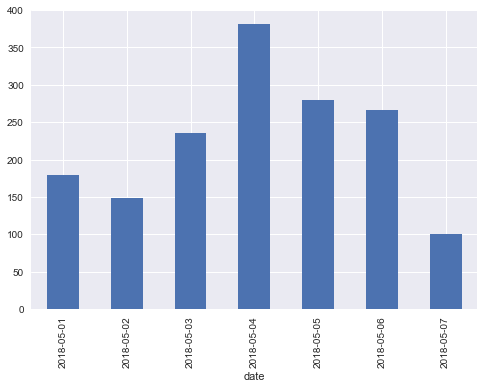

In [30]:
YH_df["date"] = pd.to_datetime(YH_df["created_at"], errors='coerce')
YH_df.groupby(YH_df["date"].dt.date).date.count().plot(kind="bar")

# WordCloud (only noun)

In [31]:
YH_df = YH_df[YH_df['text'].notnull()]

In [62]:
#ÂçäËßíËã±Â≠ó
alphaReg = re.compile(r'^[a-zA-Z]+$')
def isalpha(s):
    return alphaReg.match(s) is not None

In [63]:
# janome ÂΩ¢ÊÖãÁ¥†ÂàÜËß£
def janome_analysis(sentences, output):
    t = Tokenizer()
    words_count = defaultdict(int)
    words = []
    for sentence in sentences:
        tokens = t.tokenize(sentence)
        for token in tokens:
            # ÂìÅË©û„ÇíÂèñ„ÇäÂá∫„Åó
            partOfSpeech1 = token.part_of_speech.split(',')[0]
            partOfSpeech2 = token.part_of_speech.split(',')[1]
            
            if output == "normal":
                if partOfSpeech2 == 'Âõ∫ÊúâÂêçË©û' or partOfSpeech1 == 'ÂΩ¢ÂÆπË©û':
#                     if (token.base_form != ':' and 
#                         token.base_form != '@' and
#                         token.base_form != 'RT'):
    #                    token.base_form != '#' and 
    #                     token.base_form != '-' and
    #                     token.base_form != '/' and
    #                     token.base_form != '(' and
    #                     token.base_form != ')' and
    #                     token.base_form != '.'):
                    if isalpha(token.base_form) == False: 
                        words_count[token.base_form] += 1
                        words.append(token.base_form)
            elif output == "cloud":
                if partOfSpeech1 == 'ÂêçË©û':

                    words_count[token.base_form] += 1
                    words.append(token.base_form)
    return words_count, words

In [57]:
texts = YH_df['text'].str.replace('http\S+', '', case=False)
words_count, words = janome_analysis(texts, "cloud")
text = ' '.join(words)

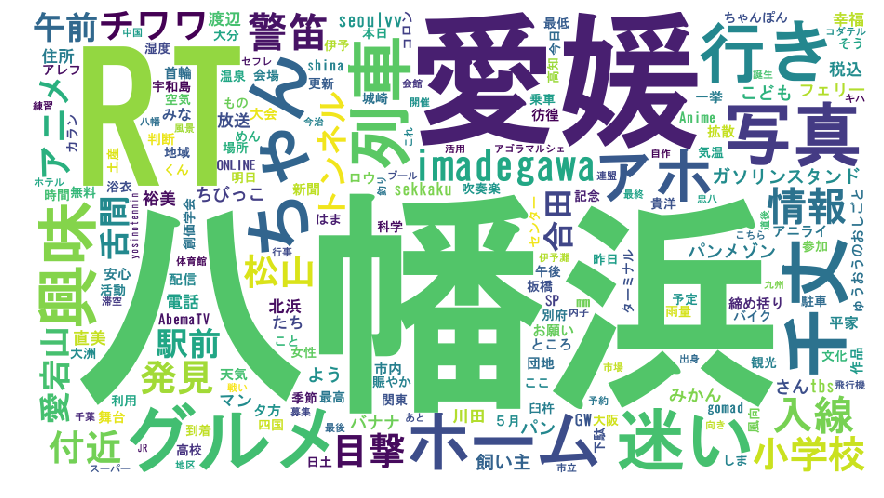

In [58]:
fpath = "C:\Windows\Fonts\HGRGE.TTC"
#word cloud
wordcloud = WordCloud(background_color="white", font_path=fpath, width=900, height=500, collocations=False).generate(text)

plt.figure(figsize=(15,12))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Explore frequent word (proper nouns and adjective)

In [64]:
YH_wo_rt = YH_df[YH_df['RT']==False]
YH_wo_rt = YH_wo_rt['text'].str.replace('http\S+', '', case=False)

In [65]:
words_count2, words2 = janome_analysis(YH_wo_rt, "normal")

In [66]:
Counter(words2).most_common()[:5]

[('ÂÖ´Âπ°Êµú', 826), ('ÊÑõÂ™õ', 274), ('ÊùæÂ±±', 58), ('ÂÆáÂíåÂ≥∂', 37), ('„ÅÑ„ÅÑ', 36)]

# Sentiment analysis

In [38]:
class CorpusElement:
    def __init__(self, text='', tokens=[], pn_scores=[]):
        self.text = text # „ÉÜ„Ç≠„Çπ„ÉàÊú¨Êñá
        self.tokens = tokens # ÊßãÊñáÊú®Ëß£Êûê„Åï„Çå„Åü„Éà„Éº„ÇØ„É≥„ÅÆ„É™„Çπ„Éà
        self.pn_scores = pn_scores # ÊÑüÊÉÖÊ•µÊÄßÂÄ§(ÂæåËø∞)


# CorpusElement„ÅÆ„É™„Çπ„Éà
naive_corpus = []

naive_tokenizer = Tokenizer()

for text in YH_wo_rt:
    tokens = naive_tokenizer.tokenize(text)
    element = CorpusElement(text, tokens)
    naive_corpus.append(element)

# ÊúÄÂàù„ÅÆ1ÊñáÁ´†„ÅÆÂΩ¢ÊÖãÁ¥†Ëß£ÊûêÁµêÊûú„ÇíË°®Á§∫
# for token in naive_corpus[0].tokens:
#     print(token)

In [39]:
# pn_ja.dic„Éï„Ç°„Ç§„É´„Åã„Çâ„ÄÅÂçòË™û„Çí„Ç≠„Éº„ÄÅÊ•µÊÄßÂÄ§„ÇíÂÄ§„Å®„Åô„ÇãËæûÊõ∏„ÇíÂæó„Çã
def load_pn_dict():
    dic = {}
    
    with codecs.open('./pn_ja.dic', 'r', 'shift_jis') as f:
        lines = f.readlines()
        
        for line in lines:
            # ÂêÑË°å„ÅØ"ËâØ„ÅÑ:„Çà„ÅÑ:ÂΩ¢ÂÆπË©û:0.999995"
            columns = line.split(':')
            dic[columns[0]] = float(columns[3])
            
    return dic

In [40]:
# „Éà„Éº„ÇØ„É≥„É™„Çπ„Éà„Åã„ÇâÊ•µÊÄßÂÄ§„É™„Çπ„Éà„ÇíÂæó„Çã
def get_pn_scores(tokens, pn_dic):
    scores = []
    
    for surface in [t.surface for t in tokens if t.part_of_speech.split(',')[0] in ['ÂãïË©û','ÂêçË©û', 'ÂΩ¢ÂÆπË©û', 'ÂâØË©û']]:
        if surface in pn_dic:
            scores.append(pn_dic[surface])
    
    if len(scores) == 0:
        scores.append(0)
    
    return scores

In [41]:
# ÊÑüÊÉÖÊ•µÊÄßÂØæÂøúË°®„ÅÆ„É≠„Éº„Éâ
pn_dic = load_pn_dict()

# ÂêÑÊñáÁ´†„ÅÆÊ•µÊÄßÂÄ§„É™„Çπ„Éà„ÇíÂæó„Çã
for element in naive_corpus:
    element.pn_scores = get_pn_scores(element.tokens, pn_dic)

In [42]:
# Âπ≥ÂùáÂÄ§„ÅåÊúÄ„ÇÇÈ´ò„ÅÑ5‰ª∂„ÇíË°®Á§∫
print('------------Show the 5 most postiive tweets------------------')
for element in sorted(naive_corpus, key=lambda e: sum(e.pn_scores)/len(e.pn_scores), reverse=True)[:5]:
    print('Average: {:.3f}'.format(sum(element.pn_scores)/len(element.pn_scores)))
    print('Title: {}'.format(io.StringIO(element.text).readline()))
    print('')


# Âπ≥ÂùáÂÄ§„ÅåÊúÄ„ÇÇ‰Ωé„ÅÑ5‰ª∂„ÇíË°®Á§∫
print('------------Show the 5 most negative tweets------------------')
for element in sorted(naive_corpus, key=lambda e: sum(e.pn_scores)/len(e.pn_scores))[:5]:
    print('Average: {:.3f}'.format(sum(element.pn_scores)/len(element.pn_scores)))
    print('Title: {}'.format(io.StringIO(element.text).readline()))
    print('')

#     for surface in [t.surface for t in element.tokens if t.part_of_speech.split(',')[0] in ['ÂãïË©û','ÂêçË©û', 'ÂΩ¢ÂÆπË©û', 'ÂâØË©û']]:
#         if surface in pn_dic:
#             print(surface)
    
#     print(element.pn_scores)
#     print('')

------------Show the 5 most postiive tweets------------------
Average: 0.988
Title: „Ç¢„É°„Éñ„É≠„ÇíÊõ¥Êñ∞„Åó„Åæ„Åó„Åü„ÄÇ „Äé„Ç¢„Ç¥„É©„Éû„É´„Ç∑„Çß„Å´BIG„Å™„ÅäÂÆ¢Êßò„Äè #ÂÖ´Âπ°Êµú #„Éü„Ç´„Éï„Çß„Éº„Éà


Average: 0.988
Title: „Ç¢„É°„Éñ„É≠„ÇíÊõ¥Êñ∞„Åó„Åæ„Åó„Åü„ÄÇ „Äé„Ç¢„Ç¥„É©„Éû„É´„Ç∑„Çß„Å´BIG„Å™„ÅäÂÆ¢Êßò„Äè #ÂÖ´Âπ°Êµú #„Éü„Ç´„Éï„Çß„Éº„Éà


Average: 0.986
Title: ÂÖ´Âπ°ÂÆø


Average: 0.969
Title: ÊòéÂæåÊó•„Å´„ÅØÂÖ´Âπ°Êµú„Å´„ÅÑ„Åë„ÇãÔºÅ

Average: 0.964
Title: ÂÖ´Âπ°Êµú„Å™„ÇâÈØõ„Çà„Çä„ÇÇÈØµ„ÇíÈ£ü„Åπ„Åæ„Åõ„ÅÜ 

------------Show the 5 most negative tweets------------------
Average: -0.980
Title: üöåÂæÖ„Å°‰∏≠


Average: -0.968
Title: GW„ÅØÂÖ´Âπ°Êµú„ÇÇÂøô„Åó„ÅÑüôÅ


Average: -0.963
Title: Â§ú„ÅÆ„Éï„Çß„É™„Éº‰πó„ÇäÂ†¥„Å£„Å¶„ÄÅ„Å™„Çì„Åã„ÉØ„ÇØ„ÉØ„ÇØ„Åô„Çã„Çà„Å≠„ÄÄ#ÂÖ´Âπ°Êµú 

Average: -0.958
Title: ÂÖ´Âπ°Êµú„ÅØÈõ®„ÇÑ‚òÇÔ∏è

Average: -0.951
Title: Áõ∏Ê®°Âéü„Åã„Çâ17ÊôÇÈñì„ÄÇÂÖ´Âπ°Êµú„Åæ„ÅßÂ∏∞„Å£„Å¶Êù•„Åæ„Åó„Åü„ÄÇ 



# Check the most retweeted tweet

In [43]:
for i in range(5):
    print('num of retweet: ', YH_df['text'].value_counts().tolist()[i])
    print(YH_df['text'].value_counts().index.tolist()[i])
    print('')
    print('------------------------------------------------------------------')

num of retweet:  219
RT @imadegawa075: ÂÖ´Âπ°ÊµúË°å„ÅçÂÖ•Á∑öÊôÇ„Å´„Éõ„Éº„É†„Å´Ë∂≥„Çí‰∏ã„Çç„Åù„ÅÜ„Å®„Åó„Å¶„Åü„Å≠„Éº„Å°„ÇÉ„Çì„Åå„Åæ„ÅüË≠¶Á¨õÈ≥¥„Çâ„Åï„Çå„Å¶„Åü„ÄÇ„ÇÇ„ÅÜ„Ç¢„Éõ„Å†„Çç„ÄÇ
„Å°„Å™„Åø„Å´ÂàóËªä„ÅÆÂÜôÁúü„ÇíÊíÆ„Çã‰∫∫„ÅØ„Åª„Å®„Çì„Å©„ÅÑ„Å™„ÅÑ„ÄÇËààÂë≥„Å™„ÅÑ„ÅÆ„Åå„Çà„ÅèÂàÜ„Åã„Çã„ÄÇ https://t.co/CAbxyNqah4

------------------------------------------------------------------
num of retweet:  130
RT @seoulvv: ÂÖ´Âπ°ÊµúÂ∏ÇÂçÉ‰∏à„Å´„Å¶Èªí„ÅÆ„ÉÅ„ÉØ„ÉØÁô∫Ë¶ã„ÄÇÊï∞Êó•Ââç„ÅØÊÑõÂÆïÂ±±„Éà„É≥„Éç„É´‰ªòËøë„ÄÅÂêàÁî∞„ÄÅËàåÈñì„ÄÅÂÖ´‰ª£„Åß„ÇÇÁõÆÊíÉ„Åï„Çå„Å¶„ÅÑ„Åæ„Åô„ÄÇ
Ëø∑„ÅÑÁä¨„Åã„ÄÅÊç®„Å¶Áä¨„ÅãÂàÜ„Åã„Çä„Åæ„Åõ„Çì„ÅåÊÉÖÂ†±Ëºâ„Åõ„Å¶„Åä„Åç„Åæ„Åô„ÄÇ

5/3(Êú®)ÂçàÂâç8:50
ÂÖ´Âπ°ÊµúÂ∏ÇÂçÉ‰∏àÈßÖÂâç„ÅÆ„Ç¨„ÇΩ„É™„É≥„Çπ„Çø„É≥„Éâ„ÇíÊ≠©„ÅÑ„Å¶„ÅÑ„Åæ„Åó„Åü„ÄÇ

È£º„ÅÑ‰∏ªÊßò„ÅåË¶ã„Å§‚Ä¶

------------------------------------------------------------------
num of retweet:  92
RT @sekkaku_tbs: 5Êúà6Êó•ÊîæÈÄÅ„ÄÄ„Åõ„Å£„Åã„Åè„Ç∞„É´„É°‚ë£
„ÄêÂ°©„Éë„É≥„Äë77ÂÜÜÔºàÁ®éËæºÔºâ
„Äé„Éë„É≥„É°„Çæ„É≥„Äè
‰ΩèÊâÄÔºöÊÑõÂ™õÁúåÂÖ´Âπ°ÊµúÂ∏ÇÂåóÊµú